In [21]:
!pip install wandb==0.12.2

^C


In [22]:

import numpy as np
from keras.datasets import fashion_mnist
from keras.datasets import mnist
from  matplotlib import pyplot as plt
import time
import math
import wandb
import copy 

#loading data from the fashion_mnist  dataset
((xtrain, ytrain), (xtest, ytest)) = fashion_mnist.load_data()
items=["T-shirt/top", "Trouser","Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag","Ankle boot"]
ftrx=np.zeros((60000,784))
ftry=np.zeros((60000,10))
ftex=np.zeros((10000,784))
ftey=np.zeros((10000,10))
for i in range(len(xtrain)):
  ftrx[i]=xtrain[i].flatten()
  ftrx[i]=ftrx[i]/256
  ftry[i][ytrain[i]]=1
for i in range(len(xtest)):
  ftex[i]=xtest[i].flatten()
  ftex[i]=ftex[i]/256
  ftey[i][ytest[i]]=1





In [23]:
wandb.login()

True

# Q1 
```
Printing the img for each class
```

wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.13.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


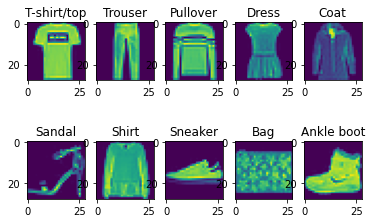

In [24]:
wandb.init(project="A1")
img=[]
for i in range(10):
  for j in range(len(ytrain)):
    if ytrain[j]==i:
      img.append(xtrain[j])
      break

#printing the images 
for i in range(len(img)):
  plt.subplot(2,5,i+1)
  plt.imshow(img[i])
  plt.title(items[i])

wandb.run.name="Q1"
wandb.log({"Images":[wandb.Image(img,caption=item) for img,item in zip(img,items)]})
wandb.finish()

# Q2


FF Neural network

In [25]:
#sigmoid function 
def sigmoid(x):
  return np.where(x>=0, 1/(1+np.exp(-x)), np.exp(x)/(1+np.exp(x)))
#grad sigmoid
def grad_sigmoid(z):
  return z*(1-z)
#softmax 
def softmax(s):
  mx=np.max(s)
  s-=mx
  out=(np.exp(s)+1e-9)/np.sum(np.exp(s)+1e-9)
  return out
#grad softmax
def grad_softmax(ya,yb):
  return ya-yb
#relu 
def Relu(x):
    return np.maximum(0, x)
#grad relu
def grad_Relu(x):
    return [1 if xi>0 else 0 for xi in x]
#tanH func
def Tanh(x):
  a= 2*np.where(x>=0, 1/(1+np.exp(-2*x)), np.exp(2*x)/(1+np.exp(2*x)))
  return a-1
#grad tanH
def grad_Tanh(x):
    return 1-Tanh(x)**2


def initgrads(n,N_units):

  dh,da,dw,db=[],[],[],[]
  dw.append(np.zeros((N_units[0],784)))
  db.append(np.zeros(N_units[0]))
  da.append(np.zeros(N_units[0]))
  dh.append(np.zeros(N_units[0]))

  for i in range(1,n):
    dw.append(np.zeros((N_units[i],N_units[i-1])))
    db.append(np.zeros(N_units[i]))
    da.append(np.zeros(N_units[i]))
    dh.append(np.zeros(N_units[i]))
  dw.append(np.zeros((10,N_units[-1])))
  db.append(np.zeros(10))
  da.append(np.zeros(10))
  dh.append(np.zeros(10))
  return dw,db,da,dh

def InitParams(x,init):
    w,b=[],[]  #list for the weights and biases
    
    if(init=='random'):
      w.append((np.random.randn(x[0],784)))
      b.append((np.random.randn(x[0])))
      l=len(x)-1
      for i in range(l):
          w.append(0.1*(np.random.randn(x[i+1],x[i])))
          b.append(0.1*(np.random.randn(x[i+1])))
      w.append(0.1*(np.random.randn(10,x[-1])))
      b.append(0.1*(np.random.randn(10)))
    else:
      w.append(np.random.randn(x[0], 784)*np.sqrt(2./(784)))
      b.append(np.zeros(x[0]))
      l=len(x)-1
      for i in range(l):
          w.append(np.random.randn(x[i+1], x[i])*np.sqrt(2./(x[i])))
          b.append(np.zeros(x[i+1]))
      w.append(np.sqrt(2./(x[-1]))*(np.random.randn(10,x[-1])))
      b.append((np.zeros(10)))

    return w,b


def sum_weights(w):
  sum=0
  for i in range(len(w)):
    sum=sum+np.sum(w[i])
  return sum


# Loss & Acc
def val_acc_loss(W,B,act_fn,ls_fn,wd):
  cost,count=0,0
  if (ls_fn=='ce'):
    for i in range(len(ftrx[54000:])):
      ypr,_,_=Feed_Frwd_Nw1(ftrx[i],W,B,act_fn,ls_fn)
      cost += (np.sum(np.multiply(ftry[i],np.log(ypr))) + wd/2*sum_weights(W) )
      if (np.argmax(ypr)==np.argmax(ftry[i])):
        count+=1
    return -cost/6000, count/6000
  #mean sq err
  elif (ls_fn=='mse'):
    for i in range(len(ftrx[54000:])):
      ypr,_,_=Feed_Frwd_Nw1(ftrx[i],W,B,act_fn,ls_fn)
      cost+=(0.5*np.sum((ftry[i]- ypr)**2) + wd/2*sum_weights(W) )
      if (np.argmax(ypr) ==np.argmax(ftry[i])):
        count+=1
    return cost/6000, count/6000

def train_acc_loss(W,B,act_fn,ls_fn,wd):
  cost,count=0,0
  if (ls_fn=='ce'):
    for i in range(len(ftrx[:54000])):
      ypr,_,_=Feed_Frwd_Nw1(ftrx[i],W,B,act_fn,ls_fn)
      cost += (np.sum(np.multiply(ftry[i],np.log(ypr))) + wd/2*sum_weights(W) )
      if (np.argmax(ypr) ==np.argmax(ftry[i])):
        count+=1
    return -cost/54000, count/54000
  #mean sq err
  elif (ls_fn=='mse'):
    for i in range(len(ftrx[:54000])):
      ypr,_,_=Feed_Frwd_Nw1(ftrx[i],W,B,act_fn,ls_fn)
      cost+=(0.5*np.sum((ftry[i]- ypr)**2) + wd/2*sum_weights(W) )
      if (np.argmax(ypr) ==np.argmax(ftry[i])):
        count+=1
    return cost/54000, count/54000




def test_acc(W,B,act_fn,ls_fn):
  count=0
  predict=[]
  matrix=np.zeros((10,10))
  for i in range(len(ftex)):
    ypr,_,_=Feed_Frwd_Nw1(ftex[i],W,B,act_fn,ls_fn)
    if (np.argmax(ypr) == ytest[i]):
      count+=1
    predict.append(np.argmax(ypr))
    matrix[ytest[i]][np.argmax(ypr)]+=1
    
  lables={}
  for i in range(len(items)):
    lables[i]=items[i]
  wandb.log({"Confusion Matrix": wandb.plot.confusion_matrix(probs=None, y_true=ytest, preds=predict,class_names=items)})
  wandb.log({"Confusion Matrix 2": wandb.plots.HeatMap(items, items, matrix),"Accuracy":count/len(ytest)})
  return count/len(ytest)


def Feed_Frwd_Nw1(xTr,w,b,act_fn,loss):
  a_i,h_i=[],[]
  a_i.append(np.dot(w[0],xTr)+b[0])  
     
  if (act_fn=='sig'):
    h_i.append(sigmoid(a_i[0]))
  elif (act_fn=='relu'):
    h_i.append(Relu(a_i[0]))
  elif (act_fn=='tanh'):
    h_i.append(Tanh(a_i[0]))

  for i in range(1,len(w)-1):
    a_i.append((np.dot(w[i],h_i[i-1])+b[i]))
    if (act_fn=='sig'):
      h_i.append(sigmoid(a_i[i]))
    elif (act_fn=='relu'):
      h_i.append(Relu(a_i[i]))
    elif (act_fn=='tanh'):
      h_i.append(Tanh(a_i[i]))
    
  a_i.append(np.dot(w[-1],h_i[-1])+b[-1])
  h_i.append(softmax(a_i[-1])) 
  yp=h_i[-1]
  
  return yp,a_i,h_i


**Test Run for Feedforward neural network**

In [26]:
n_each_layer=[128]
N=len(n_each_layer)
W,B=InitParams(n_each_layer,'xaviour')
ypr,ai,hi=Feed_Frwd_Nw1(ftrx[2],W,B,'sig','ce')
ypr

array([0.08489705, 0.23344403, 0.074161  , 0.13175948, 0.07289519,
       0.05405776, 0.02927408, 0.23570466, 0.03413393, 0.04967282])

# Q3

**Backpropagation with optimisation functions**




sgd,momentum based gradient descent,nesterov accelerated gradient descent,rmsprop,adam,nadam




In [36]:
def Back_Prop(ip,ypr,ty,a_i,h_i,W,B,N,nhl,act_fn,loss):
  k=len(ypr)
  dw,db,da,dh=initgrads(N,nhl)

  if (loss=="mse"):
    dh[-1]=(ypr-ty)
    da[-1]=dh[-1]*(ypr-ypr**2)
  elif (loss=="ce"):
    dh[-1]=[-(t/ypr) if t==1 else 0 for t in ty ]
    da[-1]=ypr-ty

  db[-1]=da[-1] 
  dw[-1]=np.dot((da[-1][:,np.newaxis]),(h_i[-2][:,np.newaxis]).T)
 
  for i in range(N-1,-1,-1):
    dh[i]=np.squeeze(np.dot(W[i+1].T,da[i+1]))
    #sigmoid
    if (act_fn=='sig'):
      da[i]=dh[i]*grad_sigmoid(h_i[i])
    #tanh
    elif (act_fn=='tanh'):
      da[i]=dh[i]*grad_Tanh(a_i[i])
    #relu
    elif (act_fn=='relu'):
      da[i]=dh[i]*grad_Relu(a_i[i])
    db[i]=np.copy(da[i])

    if (i==0):
      dw[i]=np.dot(da[i][:,np.newaxis],ip[:,np.newaxis].T)
    else:
      dw[i]=np.dot(da[i][:,np.newaxis],h_i[i-1][:,np.newaxis].T)

  return dw,db



def gradDecent(ftrx,ftry,init,wd,eta,N,nhl,act_fn,Ls_fun,epochs,batchsize):
  W,B=InitParams(nhl,init)
  e=0
  while(epochs>0):
    e=e+1
    epochs-=1
    start = time.time()

    uw,ub,_,_=initgrads(N,nhl)
    for i in range(len(ftrx[:54000])):
      pred_y,ai,hi=Feed_Frwd_Nw1(ftrx[i],W,B,act_fn,Ls_fun)
      gw,gb=Back_Prop(ftrx[i],pred_y,ftry[i],ai,hi,W,B,N,nhl,act_fn,Ls_fun)

      for j in range(len(gw)):
        uw[j]=np.add(uw[j],gw[j]+wd*W[j])
        ub[j]=np.add(ub[j],gb[j]+wd*B[j])

      if((i+1)%batchsize==0 or i==53999):
        for k in range(len(gw)):
          W[k]=np.subtract(W[k],eta*uw[k]/batchsize)
          B[k]=np.subtract(B[k],eta*ub[k]/batchsize)
          uw[k]=np.subtract(uw[k],uw[k])
          ub[k]=np.subtract(ub[k],ub[k]) 

    end = time.time() 

    trloss,tracc=train_acc_loss(W,B,act_fn,Ls_fun,wd)
    vloss,vacc=val_acc_loss(W,B,act_fn,Ls_fun,wd)
    wandb.log({"epoch":e,"Train_loss":trloss,"Train_acc":tracc,"val_loss":vloss,"val_Accuracy":vacc})

  test_acc(W,B,act_fn,Ls_fun)  

  return hi,W,B




def Momentum(ftrx,ftry,init,batchsize,gamma,wd,eta,N,nhl,act_fn,Ls_fun,epochs=1):
  W,B=InitParams(nhl,init)
  vw,vb,_,_=initgrads(N,nhl)
  pw,pb,_,_=initgrads(N,nhl)
  e=0

  while(epochs>0):
    e+=1
    epochs-=1
    start = time.time()

    uw,ub,_,_=initgrads(N,nhl)
    for i in range(len(ftrx[:54000])):
      pred_y,ai,hi=Feed_Frwd_Nw1(ftrx[i],W,B,act_fn,Ls_fun)
      gw,gb=Back_Prop(ftrx[i],pred_y,ftry[i],ai,hi,W,B,N,nhl,act_fn,Ls_fun)

      for j in range(len(gw)):
        uw[j]=np.add(uw[j],gw[j]+wd*W[j])
        ub[j]=np.add(ub[j],gb[j]+wd*B[j])

      if((i+1)%batchsize==0 or i==53999):
        for k in range(len(gw)):
          
          vw[k]=np.add(gamma*pw[k],eta*uw[k]/batchsize)
          vb[k]=np.add(gamma*pb[k],eta*ub[k]/batchsize)

          W[k]=np.subtract(W[k],vw[k])
          B[k]=np.subtract(B[k],vb[k])

          pw[k]=copy.deepcopy(vw[k])
          pb[k]=copy.deepcopy(vb[k])

          uw[k]=np.subtract(uw[k],uw[k])
          ub[k]=np.subtract(ub[k],ub[k]) 
            
    end = time.time() 

    trloss,tracc=train_acc_loss(W,B,act_fn,Ls_fun,wd)
    vloss,vacc=val_acc_loss(W,B,act_fn,Ls_fun,wd)
    wandb.log({"epoch":e,"Train_loss":trloss,"Train_acc":tracc,"val_loss":vloss,"val_Accuracy":vacc})
  
  test_acc(W,B,act_fn,Ls_fun)  

  return hi,W,B


def Nesterov(ftrx,ftry,init,batchsize,gamma,wd,eta,N,nhl,act_fn,Ls_fun,epochs=1):
  W,B=InitParams(nhl,init)
  vw,vb,_,_=initgrads(N,nhl)
  pw,pb,_,_=initgrads(N,nhl)
  w,b=copy.deepcopy(W),copy.deepcopy(B)
  e=0

  while(epochs>0):
    e+=1
    epochs-=1 
    start = time.time()

    uw,ub,_,_=initgrads(N,nhl)
    for i in range(len(ftrx)):
      pred_y,ai,hi=Feed_Frwd_Nw1(ftrx[i],W,B,act_fn,Ls_fun) 
      gw,gb=Back_Prop(ftrx[i],pred_y,ftry[i],ai,hi,w,b,N,nhl,act_fn,Ls_fun)

      for j in range(len(gw)):
        uw[j]=np.add(uw[j],gw[j]+wd*W[j])
        ub[j]=np.add(ub[j],gb[j]+wd*B[j])

      if((i+1)%batchsize==0 or i==53999):
        for k in range(len(gw)):
          vw[k]=np.add(gamma*pw[k],eta*uw[k]/batchsize)
          vb[k]=np.add(gamma*pb[k],eta*ub[k]/batchsize)

          W[k]=np.subtract(W[k],vw[k])
          B[k]=np.subtract(B[k],vb[k])
          
          pw[k]=copy.deepcopy(vw[k])
          pb[k]=copy.deepcopy(vb[k])
          
          uw[k]=np.subtract(uw[k],uw[k])
          ub[k]=np.subtract(ub[k],ub[k])
        
        for k in range(len(gw)):
          w[k]=np.subtract(W[k],gamma*pw[k])
          b[k]=np.subtract(B[k],gamma*pb[k])    
    
    end = time.time() 

    trloss,tracc=train_acc_loss(W,B,act_fn,Ls_fun,wd)
    vloss,vacc=val_acc_loss(W,B,act_fn,Ls_fun,wd)
    wandb.log({"epoch":e,"Train_loss":trloss,"Train_acc":tracc,"val_loss":vloss,"val_Accuracy":vacc})

  test_acc(W,B,act_fn,Ls_fun)  

  return hi,W,B

def rmsprop(ftrx,ftry,init,batchsize,eps,beta,wd,eta,N,nhl,act_fn,Ls_fun,epochs=1):
  W,B=InitParams(nhl,init)
  vw,vb,_,_=initgrads(N,nhl)
  e=0
  while(epochs>0):
    e+=1
    epochs-=1
    start = time.time()

    uw,ub,_,_=initgrads(N,nhl)
    for i in range(len(ftrx[:54000])):
      pred_y,ai,hi=Feed_Frwd_Nw1(ftrx[i],W,B,act_fn,Ls_fun)
      gw,gb=Back_Prop(ftrx[i],pred_y,ftry[i],ai,hi,W,B,N,nhl,act_fn,Ls_fun)

      for j in range(len(gw)):
        uw[j]=np.add(uw[j],gw[j]+wd*W[j])
        ub[j]=np.add(ub[j],gb[j]+wd*B[j])

      if((i+1)%batchsize==0 or i==53999):
        for k in range(len(gw)):
          vw[k]=np.add(beta*vw[k],(1-beta)*uw[k]**2)
          vb[k]=np.add(beta*vb[k],(1-beta)*ub[k]**2)

          W[k]=np.subtract(W[k],((eta/batchsize)/np.sqrt(vw[k]+eps))*uw[k])
          B[k]=np.subtract(B[k],((eta/batchsize)/np.sqrt(vb[k]+eps))*ub[k])

          uw[k]=np.subtract(uw[k],uw[k])
          ub[k]=np.subtract(ub[k],ub[k]) 
            
    end = time.time() 

    trloss,tracc=train_acc_loss(W,B,act_fn,Ls_fun,wd)
    vloss,vacc=val_acc_loss(W,B,act_fn,Ls_fun,wd)
    wandb.log({"epoch":e,"Train_loss":trloss,"Train_acc":tracc,"val_loss":vloss,"val_Accuracy":vacc})

  test_acc(W,B,act_fn,Ls_fun)  

  return hi,W,B




def Adam(ftrx,ftry,init,batchsize,eps,beta1,beta2,wd,eta,N,nhl,act_fn,Ls_fun,epochs=1):
  W,B=InitParams(nhl,init)
  vw,vb,_,_=initgrads(N,nhl)
  mw,mb,_,_=initgrads(N,nhl)
  beta1=0.9
  e=0
  t=1
  while(epochs>0):
    e+=1
    epochs-=1
    start = time.time()

    uw,ub,_,_=initgrads(N,nhl)
    for i in range(len(ftrx[:54000])):
      pred_y,ai,hi=Feed_Frwd_Nw1(ftrx[i],W,B,act_fn,Ls_fun)
      gw,gb=Back_Prop(ftrx[i],pred_y,ftry[i],ai,hi,W,B,N,nhl,act_fn,Ls_fun)

      for j in range(len(gw)):
        uw[j]=np.add(uw[j],gw[j]+wd*W[j])
        ub[j]=np.add(ub[j],gb[j]+wd*B[j])

      if((i+1)%batchsize==0 or i==53999):
        t+=1
        for k in range(len(gw)):
          vw[k]=np.add(beta2*vw[k],(1-beta2)*uw[k]**2)
          vb[k]=np.add(beta2*vb[k],(1-beta2)*ub[k]**2)

          mw[k]=np.add(beta1*mw[k],(1-beta1)*uw[k])
          mb[k]=np.add(beta1*mb[k],(1-beta1)*ub[k])

          mw[k]/=(1-np.power(beta1,t,dtype=np.float64))
          mb[k]/=(1-np.power(beta1,t,dtype=np.float64))

          vw[k]=np.divide(vw[k],(1-np.power(beta2,t,dtype=np.float64)))
          vb[k]=np.divide(vb[k],(1-np.power(beta2,t,dtype=np.float64)))

          W[k]=np.subtract(W[k],((eta/batchsize)/np.sqrt(vw[k]+eps))*mw[k])
          B[k]=np.subtract(B[k],((eta/batchsize)/np.sqrt(vb[k]+eps))*mb[k])

          uw[k]=np.subtract(uw[k],uw[k])
          ub[k]=np.subtract(ub[k],ub[k]) 
            
    end = time.time() 

    trloss,tracc=train_acc_loss(W,B,act_fn,Ls_fun,wd)
    vloss,vacc=val_acc_loss(W,B,act_fn,Ls_fun,wd)
    wandb.log({"epoch":e,"Train_loss":trloss,"Train_acc":tracc,"val_loss":vloss,"val_Accuracy":vacc})

  test_acc(W,B,act_fn,Ls_fun)  
  
  return hi,W,B








def NAdam(ftrx,ftry,init,batchsize,eps,beta1,beta2,wd,eta,N,nhl,act_fn,Ls_fun,epochs=1):
  W,B=InitParams(nhl,init)
  vw,vb,_,_=initgrads(N,nhl)
  mw,mb,_,_=initgrads(N,nhl)
  beta1=0.9
  e=0
  t=1
  while(epochs>0):
    e+=1
    epochs-=1
    start = time.time()

    uw,ub,_,_=initgrads(N,nhl)
    for i in range(len(ftrx[:54000])):
      pred_y,ai,hi=Feed_Frwd_Nw1(ftrx[i],W,B,act_fn,Ls_fun)
      gw,gb=Back_Prop(ftrx[i],pred_y,ftry[i],ai,hi,W,B,N,nhl,act_fn,Ls_fun)

      for j in range(len(gw)):
        uw[j]=np.add(uw[j],gw[j]+wd*W[j])
        ub[j]=np.add(ub[j],gb[j]+wd*B[j])

      if((i+1)%batchsize==0 or i==53999):
        t+=1
        for k in range(len(gw)):
          vw[k]=np.add(beta2*vw[k],(1-beta2)*uw[k]**2)
          vb[k]=np.add(beta2*vb[k],(1-beta2)*ub[k]**2)

          mw[k]=np.add(beta1*mw[k],(1-beta1)*uw[k])
          mb[k]=np.add(beta1*mb[k],(1-beta1)*ub[k])

          mw[k]/=(1-np.power(beta1,t,dtype=np.float64))
          mb[k]/=(1-np.power(beta1,t,dtype=np.float64))

          vw[k]=np.divide(vw[k],(1-np.power(beta2,t,dtype=np.float64)))
          vb[k]=np.divide(vb[k],(1-np.power(beta2,t,dtype=np.float64)))

          W[k]=np.subtract(W[k],((eta/batchsize)/np.sqrt(vw[k]+eps))*((beta1*mw[k]+(1-beta1)*uw[k])/(1-beta1**t)))
          B[k]=np.subtract(B[k],((eta/batchsize)/np.sqrt(vb[k]+eps))*((beta1*mb[k]+(1-beta1)*ub[k])/(1-beta1**t)))

          uw[k]=np.subtract(uw[k],uw[k])
          ub[k]=np.subtract(ub[k],ub[k]) 
            
    end = time.time() 

    trloss,tracc=train_acc_loss(W,B,act_fn,Ls_fun,wd)
    vloss,vacc=val_acc_loss(W,B,act_fn,Ls_fun,wd)
    wandb.log({"epoch":e,"Train_loss":trloss,"Train_acc":tracc,"val_loss":vloss,"val_Accuracy":vacc})

  test_acc(W,B,act_fn,Ls_fun)  

  return hi,W,B
 

# Q4-Q7

Sweep config and train function

In [28]:
s_config = {'method'    : "random",'metric' : {'name': 'val_Accuracy','goal':'maximize'},
'parameters': {
  'optimizer' : {'values': ['sgd','gd','momentum','nesterov','rmsprop','adam','nadam']},
  'hidden_layer_size' : {'values':[32, 64,16,20,128,50]},
  'num_hidden_layers' : {'values':[1,2,3,5] },
  'activation'        : {'values':['sig','relu','tanh']},
  'lossfun'           : {'values':['ce']},
  'lr' : {'values':[0.02,0.045,0.003,0.008,0.0065,0.0015,0.0025,0.002,0.009,0.015,0.007,0.000095,0.0004,0.0045,0.0003,0.0009,0.06,0.075,0.05,0.085,0.025,0.0055,0.01,0.04,0.004,0.35,0.0000055,0.08,0.00035,0.0075,0.065,0.006,0.0007,0.0035,0.000065,0.1,0.00075,0.0008,0.095,0.25,0.005,0.0095,0.000015,0.00001,0.0001,0.00055,0.035,0.00045,0.000045,0.00095,0.0085]},
  'weights_initializer':{'values':['random','Xavier']},
  'epochs'             :{'values':[5,10,6,8,15]},
  'weightDecay'        :{'values':[0,0.005,0.0005,0.00005,0.0006]},
  'batchsize'          :{'values':[16,32,64,128]},
  }
}

In [29]:
def train():

  hyperparameter=dict(
      epochs = 5,                                       
      batchsize = 10,                                                    
      weightDecay = 0.00005,                                            
      hidden_layer_size = 128,
      weights_initializer='Xaviuor',                               
      lr=0.0095,
      activation='tanh',                                             
      optimizer = "adam",                      
      num_hidden_layers= 3,           
      lossfun = "ce",
      
  )

  wandb.init(config=hyperparameter)

  config=wandb.config
  wandb.run.name = "e_{}_hls_{}_numhl_{}_opt_{}_bs_{}_init_{}_ac_{}_loss_{}_learning_rate_{}_wdecay_{}".format(config.epochs,\
  config.hidden_layer_size,\
  config.num_hidden_layers,\
  config.optimizer,\
  config.batchsize,\
  config.weights_initializer,\
  config.activation,\
  config.lossfun,\
  config.lr,\
  config.weightDecay)
  
  opt_size=10                                      
  nrl=[config.hidden_layer_size for i in range(config.num_hidden_layers)]  
  #gradientdecent
  if(config.optimizer=="sgd"):
    param=gradDecent(ftrx,ftry,config.weights_initializer,config.weightDecay,config.lr,config.num_hidden_layers,nrl,config.activation,config.lossfun,config.epochs,1)
  if(config.optimizer=="gd"):
    param=gradDecent(ftrx,ftry,config.weights_initializer,config.weightDecay,config.lr,config.num_hidden_layers,nrl,config.activation,config.lossfun,config.epochs,config.batchsize)
  #adam
  elif(config.optimizer=="adam"):
    param=Adam(ftrx,ftry,config.weights_initializer,config.batchsize,1e-8,0.9,0.9,config.weightDecay,config.lr,config.num_hidden_layers,nrl,config.activation,config.lossfun,config.epochs)
  #nadam
  elif(config.optimizer=="nadam"):
    param=NAdam(ftrx,ftry,config.weights_initializer,config.batchsize,1e-8,0.9,0.9,config.weightDecay,config.lr,config.num_hidden_layers,nrl,config.activation,config.lossfun,config.epochs)
  #momentum
  elif(config.optimizer=="momentum"):
    param=Momentum(ftrx,ftry,config.weights_initializer,config.batchsize,0.9,config.weightDecay,config.lr,config.num_hidden_layers,nrl,config.activation,config.lossfun,config.epochs)
  #nesterov
  elif(config.optimizer=="nesterov"):
    param=Nesterov(ftrx,ftry,config.weights_initializer,config.batchsize,0.9,config.weightDecay,config.lr,config.num_hidden_layers,nrl,config.activation,config.lossfun,config.epochs)
  #rmsprop
  elif(config.optimizer=="rmsprop"):
    param=rmsprop(ftrx,ftry,config.weights_initializer,config.batchsize,1e-8,0.8,config.weightDecay,config.lr,config.num_hidden_layers,nrl,config.activation,config.lossfun,config.epochs)

In [ ]:
sweep_id = wandb.sweep(s_config,project='A1')
wandb.agent(sweep_id,train,project='A1',count=150)

# Q8

**Sweep config for comparing MSE and Crossentropy**

In [30]:
s_mse_ce_config = {
'method'    : "grid",
'metric'    : {'name': 'val_Accuracy','goal':'maximize'},
'parameters': {
  'optimizer' : {'values': ['adam']},
  'hidden_layer_size': {'values':[128]},
  'num_hidden_layers': {'values':[3] },
  'activation': {'values':['tanh']},
  'lossfun': {'values':['ce','mse']},
  'lr': {'values':[0.0095]},
  'weights_initializer': {'values':['Xavier']},
  'epochs':{'values':[15]},
  'weightDecay':{'values':[0.00005]},
  'batchsize':{'values':[32]},
  }
}

In [31]:
sweep_id = wandb.sweep(s_mse_ce_config ,project='MSE VS CE')
wandb.agent(sweep_id,train,project='MSE VS CE')

Create sweep with ID: qpylk9vw
Sweep URL: https://wandb.ai/karanwxlia/MSE%20VS%20CE/sweeps/qpylk9vw


wandb: Agent Starting Run: vrno9w8q with config:
wandb: 	activation: tanh
wandb: 	batchsize: 32
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 128
wandb: 	lossfun: ce
wandb: 	lr: 0.0095
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weightDecay: 5e-05
wandb: 	weights_initializer: Xavier
wandb: wandb version 0.13.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: Visualizing heatmap.


Accuracy,0.8744
Train_acc,0.91594
Train_loss,0.22979
epoch,15
val_Accuracy,0.91633
val_loss,0.22601


Accuracy,▁
Train_acc,▁▃▅▅▆▆▇▇▇▇▇████
Train_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
val_Accuracy,▁▃▅▅▆▆▇▇▇▇▇████
val_loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁


wandb: Agent Starting Run: mv93p7d7 with config:
wandb: 	activation: tanh
wandb: 	batchsize: 32
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 128
wandb: 	lossfun: mse
wandb: 	lr: 0.0095
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weightDecay: 5e-05
wandb: 	weights_initializer: Xavier
wandb: wandb version 0.13.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: Visualizing heatmap.


Accuracy,0.8722
Train_acc,0.90539
Train_loss,0.07044
epoch,15
val_Accuracy,0.90467
val_loss,0.07066


Accuracy,▁
Train_acc,▁▄▆▆▇▇▇▇▇▇█████
Train_loss,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
val_Accuracy,▁▄▅▆▆▇▇▇▇▇█████
val_loss,█▅▃▃▃▂▂▂▂▂▁▁▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


# Q 10

**Getting the train and test set from the mnist data**

In [32]:
((xtrain, ytrain), (xtest, ytest)) = mnist.load_data()
items=["0", "1","2", "3", "4", "5", "6", "7", "8","9"]

ftex=np.zeros((10000,784))
ftey=np.zeros((10000,10))
ftrx=np.zeros((60000,784))
ftry=np.zeros((60000,10))

for i in range(len(xtrain)):
  ftrx[i]=xtrain[i].flatten()
  ftrx[i]=ftrx[i]/256
  ftry[i][ytrain[i]]=1
for i in range(len(xtest)):
  ftex[i]=xtest[i].flatten()
  ftex[i]=ftex[i]/256
  ftey[i][ytest[i]]=1

**Hyperparameter config 1**

In [33]:
wandb.init(project="A1")
epochs = 15                                       
batchsize = 32                                                    
weightDecay = 0.00005                                           
hidden_layer_size = 128
weights_initializer='Xaviuor'                               
lr=0.0095
activation='tanh'                                            
optimizer = "adam"                      
num_hidden_layers= 3           
lossfun = "mse"

wandb.run.name="e_{}_hls_{}_numhl_{}_opt_{}_bs_{}_init_{}_ac_{}_loss_{}_learning_rate_{}_wdecay_{}".format(epochs,\
hidden_layer_size,\
num_hidden_layers,\
optimizer,\
batchsize,\
weights_initializer,\
activation,\
lossfun,\
lr,\
weightDecay)
nhl=[hidden_layer_size for i in range(num_hidden_layers)]
param=Adam(ftrx,ftry,weights_initializer,batchsize,1e-8,0.9,0.9,weightDecay,lr,num_hidden_layers,nhl,activation,lossfun,epochs)
  

wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.13.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: Visualizing heatmap.


**Hyperparameter config 2**

In [34]:
wandb.init(project="A1")
epochs = 15                                       
batchsize = 32                                                    
weightDecay = 0.00005                                           
hidden_layer_size = 64
weights_initializer='Xaviuor'                               
lr=0.0055
activation='tanh'                                            
optimizer = "nadam"                      
num_hidden_layers= 1           
lossfun = "ce"

wandb.run.name="e_{}_hls_{}_numhl_{}_opt_{}_bs_{}_init_{}_ac_{}_loss_{}_learning_rate_{}_wdecay_{}".format(epochs,\
hidden_layer_size,\
num_hidden_layers,\
optimizer,\
batchsize,\
weights_initializer,\
activation,\
lossfun,\
lr,\
weightDecay)
nhl=[hidden_layer_size for i in range(num_hidden_layers)]
param=NAdam(ftrx,ftry,weights_initializer,batchsize,1e-8,0.9,0.9,weightDecay,lr,num_hidden_layers,nhl,activation,lossfun,epochs)

wandb: WARNING Ignored wandb.init() arg project when running a sweep


Accuracy,0.9688
Train_acc,0.98183
Train_loss,0.01429
epoch,15
val_Accuracy,0.98367
val_loss,0.01273


Accuracy,▁
Train_acc,▁▅▆▇▇▇█████████
Train_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
val_Accuracy,▁▅▆▇▇██████████
val_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁


wandb: wandb version 0.13.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: Visualizing heatmap.


**Hyperparameter config 3**

In [35]:
wandb.init(project="A1")
epochs = 15                                       
batchsize = 32                                                    
weightDecay = 0.00005                                           
hidden_layer_size = 32
weights_initializer='Xaviuor'                               
lr=0.04
activation='relu'                                            
optimizer = "nadam"                      
num_hidden_layers= 2           
lossfun = "ce"

wandb.run.name="e_{}_hls_{}_numhl_{}_opt_{}_bs_{}_init_{}_ac_{}_loss_{}_learning_rate_{}_wdecay_{}".format(epochs,\
hidden_layer_size,\
num_hidden_layers,\
optimizer,\
batchsize,\
weights_initializer,\
activation,\
lossfun,\
lr,\
weightDecay)
nhl=[hidden_layer_size for i in range(num_hidden_layers)]
param=NAdam(ftrx,ftry,weights_initializer,batchsize,1e-8,0.9,0.9,weightDecay,lr,num_hidden_layers,nhl,activation,lossfun,epochs)

wandb: WARNING Ignored wandb.init() arg project when running a sweep


Accuracy,0.962
Train_acc,0.96978
Train_loss,0.10894
epoch,15
val_Accuracy,0.975
val_loss,0.09646


Accuracy,▁
Train_acc,▁▄▅▆▆▆▇▇▇▇█████
Train_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
val_Accuracy,▁▄▅▆▆▇▇▇▇▇█████
val_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁


wandb: wandb version 0.13.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: Visualizing heatmap.
